<a href="https://colab.research.google.com/github/joncalle/ML1/blob/main/Graded_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DAB200 -- Graded Lab 3

In this lab, you will gain some experience in dealing with missing data and further practice converting non-numeric features in a dataset to numeric.

**Target**: to predict `Comb Unadj FE - Conventional Fuel`

**Data set**: make sure you use the data assigned to your group!

| Groups | Data set |
| :-: | :-: |
| 1-3 | veh14_missing.csv |
| 4-5 | veh15_missing.csv |
| 6-8 | veh16_missing.csv |
| 9-11 | veh17_missing.csv |
| 12-14 | veh18_missing.csv |
| 15-17 | veh19_missing.csv |

**Important Notes:**
- Use [Chapter 7](https://mlbook.explained.ai/bulldozer-intro.html) of the textbook as a **guide**:
     - you only need to use **random forest** models;
- Code submitted for this lab should be:
     - error free
         - to make sure this is the case, before submitting, close all Jupyter notebooks, exit Anaconda, reload the lab notebook and execute all cells
     - final code
         - this means that I don't want to see every piece of code you try as you work through this lab but only the final code; only the code that fulfills the objective
- Use the **out-of-bag score** to evaluate models
     - Read Section 5.2 carefully so that you use this method properly
     - The oob score that you provide should be the average of 10 runs
- Don't make assumptions!


### Part 0

Please provide the following information:
 - Group Number:   12
 - Group Members
     - Jonathan Alberto Calle Zuniga (0825959)
     - Jonathan Chukwuma OTEH (0775057)
     - Ali Salman (0840471)

### Part 1 - Create and evaluate an initial model

In this part you should:
 - use Section 7.3 of the textbook as a guide, except:
     - use all of the data; and
     - use 150 decision trees in your random forest models
 - read in the data
 - isolate all numeric features from original data set
 - fill in any missing values with 0
 - create and evaluate a baseline model

#### Code (10 marks)

In [45]:
!pip install rfpimp
!pip install category_encoders

In [46]:
import numpy as np
import pandas as pd
import warnings
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_string_dtype
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from rfpimp import *

In [65]:
def evaluate(X, y, n_estimators=150):
    oob_scores = []
    r2 = []
    for i in range(10):
        rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, oob_score=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        rf.fit(X_train, y_train)
        oob_scores.append(rf.oob_score_)
        r2.append(rf.score(X_train, y_train))
        n = rfnnodes(rf)
        h = np.median(rfmaxdepths(rf))
    avg_oob = sum(oob_scores) / len(oob_scores)
    avg_r2 = sum(r2) / len(r2)
    print("Number of trees:",n_estimators)
    print(f"Average OOB score over 10 runs for baseline model is: {avg_oob:.4f}")
    print(f"Average of R^2 over 10 runs for model_2 is: {avg_r2:.4f}")
    return rf, avg_oob


def showimp(rf, X, y):
    features = list(X.columns)
    I = importances(rf, X, y, features=features)
    plot_importances(I, color='silver')


def sniff_modified(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

def df_normalize_strings(df, patt):
    for col in df.columns:
        if is_string_dtype(df[col]) or is_object_dtype(df[col]):
            df[col] = df[col].str.lower()
            df[col] = df[col].fillna(np.nan)
            df[col] = df[col].replace(patt, np.nan)

def df_string_to_cat(df):
    for col in df.columns:
        if is_string_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()

def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1


# Filling the missing values with median
def fix_missing_num(df, colname):
    df[colname].fillna(df[colname].median(), inplace=True)

In [48]:
df = pd.read_csv('https://github.com/joncalle/ML1/blob/main/veh18_missing.csv?raw=true')
print(df.shape)
df.head().T

(1290, 12)


,0,1,2,3,4
Eng Displ,NaN,6.2,2.0,2.0,NaN
# Cyl,6,8,4,4,8
Comb Unadj FE - Conventional Fuel,26.21,21.8108,35.6914,36.7994,18.9885
# Gears,6,8,8,7,6
Max Ethanol % - Gasoline,15.0,10.0,10.0,10.0,15.0
Intake Valves Per Cyl,2,1,2,2,2
Exhaust Valves Per Cyl,2,1,2,2,2
Fuel Metering Sys Desc,Multipoint/sequential fuel injection,Spark Ignition Direct Injection,unknown,unknown,Multipoint/sequential fuel injection
Air Aspiration Method Desc,Naturally Aspirated,Naturally Aspirated,Turbocharged,Turbocharged,Naturally Aspirated
Trans Desc,XXXXX,XXXXX,Semi-Automatic,Automated Manual,XXXXX


In [49]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
# Cyl,int64,0.000000,8,"[6, 8, 4, 12, 3, 10, 5, 16]"
# Gears,int64,0.000000,8,"[6, 8, 7, 10, 9, 1, 5, 4]"
Intake Valves Per Cyl,int64,0.000000,2,"[2, 1]"
Exhaust Valves Per Cyl,int64,0.000000,2,"[2, 1]"
Eng Displ,float64,29.302326,41,"[nan, 6.2, 2.0, 4.4, 3.0, 5.2, 1.6, 2.7, 4.0, ..."
Comb Unadj FE - Conventional Fuel,float64,0.000000,1022,"[26.21, 21.8108, 35.6914, 36.7994, 18.9885, 24..."
Max Ethanol % - Gasoline,float64,2.945736,4,"[15.0, 10.0, nan, 85.0]"
Fuel Metering Sys Desc,object,0.000000,5,"[Multipoint/sequential fuel injection, Spark I..."
Air Aspiration Method Desc,object,0.000000,4,"[Naturally Aspirated, Turbocharged, Supercharg..."
Trans Desc,object,0.000000,8,"[XXXXX, Semi-Automatic, Automated Manual, Manu..."


In [50]:
df.isnull().sum()

Eng Displ                            378
# Cyl                                  0
Comb Unadj FE - Conventional Fuel      0
# Gears                                0
Max Ethanol % - Gasoline              38
Intake Valves Per Cyl                  0
Exhaust Valves Per Cyl                 0
Fuel Metering Sys Desc                 0
Air Aspiration Method Desc             0
Trans Desc                             0
Cyl Deact?                           229
Var Valve Lift?                        0
dtype: int64

In [51]:
df = df.fillna(0)
df.isnull().sum()

Eng Displ                            0
# Cyl                                0
Comb Unadj FE - Conventional Fuel    0
# Gears                              0
Max Ethanol % - Gasoline             0
Intake Valves Per Cyl                0
Exhaust Valves Per Cyl               0
Fuel Metering Sys Desc               0
Air Aspiration Method Desc           0
Trans Desc                           0
Cyl Deact?                           0
Var Valve Lift?                      0
dtype: int64

In [52]:
X1 = df.select_dtypes(include=[np.number]).drop(columns='Comb Unadj FE - Conventional Fuel', axis=1)
y1 = df['Comb Unadj FE - Conventional Fuel']
rf1, oob1 = evaluate(X1, y1)

Number of trees: 150
Average OOB score over 10 runs for baseline model is: 0.6663
Average of R^2 over 10 runs for model_2 is: 0.7456


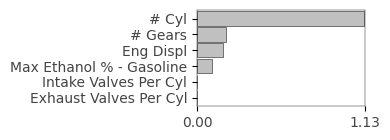

In [53]:
showimp(rf1, X1, y1)

### Part 2 - Normalize missing values

In this part you should:
 - use Section 7.4 of the textbook as a guide
 - convert **all** representations of missing data to a **single** representation

#### Code (15 marks)

In [54]:
patt = ['unknown','xxxxx','   ']
df_normalize_strings(df, patt)

In [55]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
# Cyl,int64,0.000000,8,"[6, 8, 4, 12, 3, 10, 5, 16]"
# Gears,int64,0.000000,8,"[6, 8, 7, 10, 9, 1, 5, 4]"
Intake Valves Per Cyl,int64,0.000000,2,"[2, 1]"
Exhaust Valves Per Cyl,int64,0.000000,2,"[2, 1]"
Eng Displ,float64,0.000000,41,"[0.0, 6.2, 2.0, 4.4, 3.0, 5.2, 1.6, 2.7, 4.0, ..."
Comb Unadj FE - Conventional Fuel,float64,0.000000,1022,"[26.21, 21.8108, 35.6914, 36.7994, 18.9885, 24..."
Max Ethanol % - Gasoline,float64,0.000000,4,"[15.0, 10.0, 0.0, 85.0]"
Fuel Metering Sys Desc,object,29.069767,5,"[multipoint/sequential fuel injection, spark i..."
Air Aspiration Method Desc,object,0.000000,4,"[naturally aspirated, turbocharged, supercharg..."
Trans Desc,object,41.162791,8,"[nan, semi-automatic, automated manual, manual..."


#### Question (5 marks)

Note here all the different ways missing data was represented in the data.   

**Enter your answer here:**

One way in which missing values can be shown is through the use of NaN or Nulls, indicating that a value or number is not present in the data. It should be noted that missing values can also be identified through whitespace or empty strings. Additionally, another type of missing values encountered in this dataset are placeholder values, in which case the missing values were filled with strings such as "   ", "XXXXX," and "unknown." These values were subsequently transformed into NaN within our dataset to facilitate further analysis and processing.

### Part 3 - Categorical features

In this part you should:
 - use Section 7.5.1 as a guide
 - only use ordinal encoding
 - convert **all** non-numeric features to numeric
 - handle any missing values

#### Code (25 marks)

In [56]:
warnings.filterwarnings('ignore')
df_cat = df.select_dtypes(include=[object])

df_normalize_strings(df_cat, patt)
df_string_to_cat(df_cat)
df_cat_to_catcode(df_cat)
sniff_modified(df_cat)

,data type,percent missing,No. unique,unique values
Fuel Metering Sys Desc,int8,0.0,5,"[2, 4, 0, 1, 3]"
Air Aspiration Method Desc,int8,0.0,4,"[1, 3, 2, 4]"
Trans Desc,int8,0.0,8,"[0, 7, 1, 5, 3, 6, 2, 4]"
Cyl Deact?,int8,0.0,3,"[1, 0, 2]"
Var Valve Lift?,int8,0.0,2,"[1, 2]"


In [57]:
df_cat.isnull().sum()

Fuel Metering Sys Desc        0
Air Aspiration Method Desc    0
Trans Desc                    0
Cyl Deact?                    0
Var Valve Lift?               0
dtype: int64

### Part 4 - Numeric features

In this part you should:
 - use Section 7.5.2 as a guide
 - handle any missing values

#### Code (30 marks)

In [58]:
df_num = df.select_dtypes(include=[np.number])

# Filling the missing values with median
for column_name in df_num.columns:
    print(column_name)
    fix_missing_num(df_num, column_name)

Eng Displ
# Cyl
Comb Unadj FE - Conventional Fuel
# Gears
Max Ethanol % - Gasoline
Intake Valves Per Cyl
Exhaust Valves Per Cyl


In [59]:
sniff_modified(df_num)

,data type,percent missing,No. unique,unique values
# Cyl,int64,0.0,8,"[6, 8, 4, 12, 3, 10, 5, 16]"
# Gears,int64,0.0,8,"[6, 8, 7, 10, 9, 1, 5, 4]"
Intake Valves Per Cyl,int64,0.0,2,"[2, 1]"
Exhaust Valves Per Cyl,int64,0.0,2,"[2, 1]"
Eng Displ,float64,0.0,41,"[0.0, 6.2, 2.0, 4.4, 3.0, 5.2, 1.6, 2.7, 4.0, ..."
Comb Unadj FE - Conventional Fuel,float64,0.0,1022,"[26.21, 21.8108, 35.6914, 36.7994, 18.9885, 24..."
Max Ethanol % - Gasoline,float64,0.0,4,"[15.0, 10.0, 0.0, 85.0]"


In [60]:
df_num.isna().sum()

Eng Displ                            0
# Cyl                                0
Comb Unadj FE - Conventional Fuel    0
# Gears                              0
Max Ethanol % - Gasoline             0
Intake Valves Per Cyl                0
Exhaust Valves Per Cyl               0
dtype: int64

In [61]:
df_new = pd.concat([df_cat, df_num], axis=1)
df_new

,Fuel Metering Sys Desc,Air Aspiration Method Desc,Trans Desc,Cyl Deact?,Var Valve Lift?,Eng Displ,# Cyl,Comb Unadj FE - Conventional Fuel,# Gears,Max Ethanol % - Gasoline,Intake Valves Per Cyl,Exhaust Valves Per Cyl
0,2,1,0,1,1,0.0,6,26.2100,6,15.0,2,2
1,4,1,0,0,1,6.2,8,21.8108,8,10.0,1,1
2,0,3,7,1,2,2.0,4,35.6914,8,10.0,2,2
3,0,3,1,1,1,2.0,4,36.7994,7,10.0,2,2
4,2,1,0,1,1,0.0,8,18.9885,6,15.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1285,4,1,0,0,2,0.0,6,31.9191,9,10.0,2,2
1286,4,1,5,0,1,0.0,4,42.9426,6,10.0,2,2
1287,4,1,7,1,2,0.0,8,24.8658,7,10.0,2,2
1288,4,3,7,0,1,2.0,4,33.1287,6,15.0,2,2


### Part 5 - Create and evaluate a final model

In this part you should:
 - create and evaluate a model using all the features after processing them in Parts 2, 3, and 4 above

#### Code (10 marks)

In [62]:
X2, y2 = df_new.drop(['Comb Unadj FE - Conventional Fuel'], axis=1), df_new['Comb Unadj FE - Conventional Fuel']
rf2, oob2 = evaluate(X2, y2)

Number of trees: 150
Average OOB score over 10 runs for baseline model is: 0.7720
Average of R^2 over 10 runs for model_2 is: 0.9417


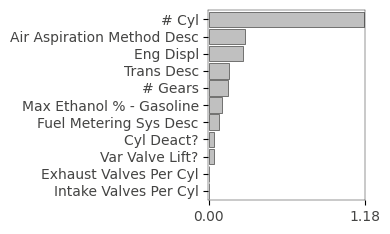

In [63]:
showimp(rf2, X2, y2)

#### Questions (5 marks)

Provide answers to the following:
 1. calculate the percent difference between the results of Part 1 and Part 5 (make sure you are using the correct formula for percent difference)
 2. based on the percent difference, state whether or not the results of Part 5 are an improvement over the results of Part 1

In [64]:
percent_difference = abs(oob1 - oob2) / ((oob1 + oob2) / 2) * 100
print(f"The percent difference between the results of Part 1 and Part 5 is: {percent_difference:.2f}%")

The percent difference between the results of Part 1 and Part 5 is: 14.70%


**Enter your answers here:**

An improvement in the model can be observed here, attributed to the normalization of missing values, utilization of ordinal encoding, conversion of non-numeric features into numeric ones, and the handling of missing values. These crucial preprocessing steps guarantee the proper formatting of our data, appropriate handling of missing values, and effective incorporation of information from non-numeric features into the final model. As a result, more accurate and reliable predictions are achieved through these steps, thanks to the integration of machine learning concepts.